# Important Variables
This section should have everything you'd normally need to edit.

In [312]:
import os
import pandas as pd

folder_path = "c:/Users/mingd/OneDrive/Documents/GitHub/newVRTesting/Eccentricity/Analysis/AnalysisCSVs"
time_delay = 150
plot_title = "VR 2D Eccentricity"
plot_x_label = "Eccentricity (°)"
ivColumnName = "Eccentricity"
plot_y_label = "reaction time (ms)"
plot_y_limits = [200, 800]

# z* value for confidence interval
z_score = 1.96  # 1.96 for 95%, 2.326 for 98%, 2.576 for 99%
p_val_threshold = 0.05  # adjust accordingly if changing z-score
left_iv_rows = [-30, 0]  # left best fit line calculated for these values
right_iv_rows =  [0,30]  # right best fit line calculated for these values

normalizeData = False

# Data pre-processing
This section imports all of the .csv files from folderPath, organizes
and then adds them to the dataframe named "data".
The organization of the "data" variable is explained thoroughly in the
next section.

In [313]:
file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
# Remove 'runData.csv' from the list if it exists
try:
    file_list.remove('runData.csv')
except ValueError:
    # 'runData.csv' was not in the list
    pass

# print out the files found
print(file_list)

['Mingda-overtrtData-2024-08-06-19-27-05.csv', 'Mingda1-overtrtData-2024-08-06-18-47-27.csv']


In [314]:
# Create an empty DataFrame with the specified columns
data = pd.DataFrame(columns=['ParticipantID', 'fileName', 'data', 'cleanedData', 'stats'])

# Imports all files in the folder, folderPath, and adds to "data"
for file_name in file_list:
    # Extract participant ID from the file name
    split_str = file_name.split("-")
    participant_id = split_str[0]

    # Import data from the CSV file
    data_import = pd.read_csv(os.path.join(folder_path, file_name))

    # Filter out incorrect trials and trials with ReactionTime > 1.2 seconds (1200 ms)
    cleaned_data = data_import[(data_import['Correct'] == True) & 
                               (data_import['ReactionTime'] - data_import['ObjShowTime'] <= 1200)]
    # Subtract the time delay from ReactionTime
    cleaned_data.loc[:, 'ReactionTime'] = cleaned_data['ReactionTime'] - time_delay

    # Extract independent variable and unique values
    independentVar = cleaned_data[ivColumnName]
    uniqueIVs = sorted(independentVar.unique())

    # Initialize a DataFrame to store data separated by independent variable
    dataSeparatedByIV = pd.DataFrame(columns=["IndependentVar", "Data", "Mean", "Std Dev", "Std Err"])

    all_outlier_indices = []

    # Iterate over each unique independent variable value
    # Dataframes keep indices constant with subsets
    for iv in uniqueIVs:
        # Get indices of the original data subset for the current IV
        originalDataIndices = cleaned_data[cleaned_data['Eccentricity'] == iv].index
        dataSubset = cleaned_data.loc[originalDataIndices]

        reactionTimes = dataSubset["ReactionTime"] - dataSubset["ObjShowTime"]

        # Function to remove outliers using 1.5 * IQR method
        Q1 = reactionTimes.quantile(0.25)
        Q3 = reactionTimes.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_indices = reactionTimes[(reactionTimes < lower_bound) | (reactionTimes > upper_bound)].index

        # Remove outliers from reaction times
        reactionTimes_no_outliers = reactionTimes.drop(outlier_indices)

        # Store indices of outliers
        all_outlier_indices.extend(outlier_indices)

        # Append the cleaned data and statistics to the DataFrame
        new_row = pd.DataFrame({
            "IndependentVar": [iv],
            "Data": [reactionTimes_no_outliers.tolist()],
            "Mean": [reactionTimes_no_outliers.mean()],
            "Std Dev": [reactionTimes_no_outliers.std()],
            "Std Err": [reactionTimes_no_outliers.sem()]
        })
        dataSeparatedByIV = pd.concat([dataSeparatedByIV, new_row], ignore_index=True)
       
    # Remove outliers from the original cleaned data
    cleaned_data_no_outliers = cleaned_data.drop(index=all_outlier_indices)

    #Get all means and standard errors
    mean_values = dataSeparatedByIV['Mean']
    std_errors = dataSeparatedByIV['Std Err']
    # Calculate the weighted mean
    weights = 1 / std_errors.values**2
    weighted_mean = (mean_values.values * weights).sum() / weights.sum()
    total_weight = weights.sum()

    # Add a row to the main DataFrame with all the information
    new_main_row = pd.DataFrame({
        'ParticipantID': [participant_id],
        'fileName': [file_name],
        'data': [data_import],
        'cleanedData': [cleaned_data_no_outliers],
        'stats': [dataSeparatedByIV],
        'weightedMean': [weighted_mean],
        'weightedStdErr': [total_weight]
    })
    data = pd.concat([data, new_main_row], ignore_index=True)

# Display the main DataFrame
print("Data:")
print(data)
print("\n\n\n")
# Display the content of each nested DataFrame for the first few rows
for idx in range(min(3, len(data))):
    print(f"ParticipantID: {data.iloc[idx]['ParticipantID']}")
    print(f"fileName: {data.iloc[idx]['fileName']}")
    # print("Original Data:")
    # print(data.iloc[idx]['data'])
    # print("Cleaned Data separated by IV:")
    # print(data.iloc[idx]['cleanedData'])
    print("Stats:")
    print(data.iloc[idx]['stats'])
    print("\n")

Data:
  ParticipantID                                     fileName  \
0        Mingda   Mingda-overtrtData-2024-08-06-19-27-05.csv   
1       Mingda1  Mingda1-overtrtData-2024-08-06-18-47-27.csv   

                                                data  \
0        CueShowTime    ObjShowTime   ReactionTim...   
1        CueShowTime    ObjShowTime   ReactionTim...   

                                         cleanedData  \
0        CueShowTime    ObjShowTime   ReactionTim...   
1        CueShowTime    ObjShowTime   ReactionTim...   

                                               stats  weightedMean  \
0    IndependentVar                              ...    398.602758   
1    IndependentVar                              ...    454.335329   

   weightedStdErr  
0        0.011030  
1        0.005362  




ParticipantID: Mingda
fileName: Mingda-overtrtData-2024-08-06-19-27-05.csv
Stats:
  IndependentVar                                               Data  \
0            -30           [364, 36

C:\Users\mingd\AppData\Local\Temp\ipykernel_8536\1378893053.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataSeparatedByIV = pd.concat([dataSeparatedByIV, new_row], ignore_index=True)
C:\Users\mingd\AppData\Local\Temp\ipykernel_8536\1378893053.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataSeparatedByIV = pd.concat([dataSeparatedByIV, new_row], ignore_index=True)


# Plotting

This section uses the pre-processed/organized data to create graphs.

## Data Organization

### Explanation of the "data" Variable:

- Each row represents a separate .csv file found in the folder.
- The "imported data" column contains the exact table imported from the .csv file.
- All trials in the "cleaned trials" column have incorrect, >1200 ms, and outliers removed, and the time delay subtracted.

#### Columns:
1. **Participant ID**: Identifier for each participant.
2. **File Name**: Name of the .csv file.
3. **Imported Data**: Raw data imported from the .csv file.
4. **Cleaned Trials**: Processed data with incorrect, >1200 ms, and outliers removed, and time delay subtracted.
5. **Stats**: Statistical analysis results.

variable names:
'ParticipantID', 'fileName', 'data', 'cleanedData', 'stats'

| Column 1         | Column 2 | Column 3      | Column 4       | Column 5 |
|------------------|----------|---------------|----------------|----------|
| Participant ID   | File Name| Imported Data | Cleaned Trials | Stats    |
| Mingda           |          |               |                |          |
| JoeBruin         |          |               |                |          |
| CElegans         |          |               |                |          |
| CatSushi         |          |               |                |          |
| ...              |          |               |                |          |

### Stats Organization

- Each row represents a different level of the independent variable (e.g., for the eccentricity experiment: -30°, -15°, 0°, 15°, 30°).
- All trials have incorrect, >1200 ms, and outliers removed, and time delay subtracted.

#### Columns:
1. **IV Name**: Name of the independent variable.
2. **Trials**: Processed trials.
3. **Mean**: Average value.
4. **Standard Deviation**: Measure of variability.
5. **Standard Error**: Estimate of the standard error.

variable names:
"IndependentVar", "Data", "Mean", "Std Dev", "Std Err"

| Column 1  | Column 2 | Column 3        | Column 4              | Column 5       |
|-----------|----------|-----------------|-----------------------|----------------|
| IV Name   | Trials   | Mean            | Standard Deviation    | Standard Error |
| IV1       |          |                 |                       |                |
| IV2       |          |                 |                       |                |
| IV3       |          |                 |                       |                |
| ...       |          |                 |                       |                |

In [315]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

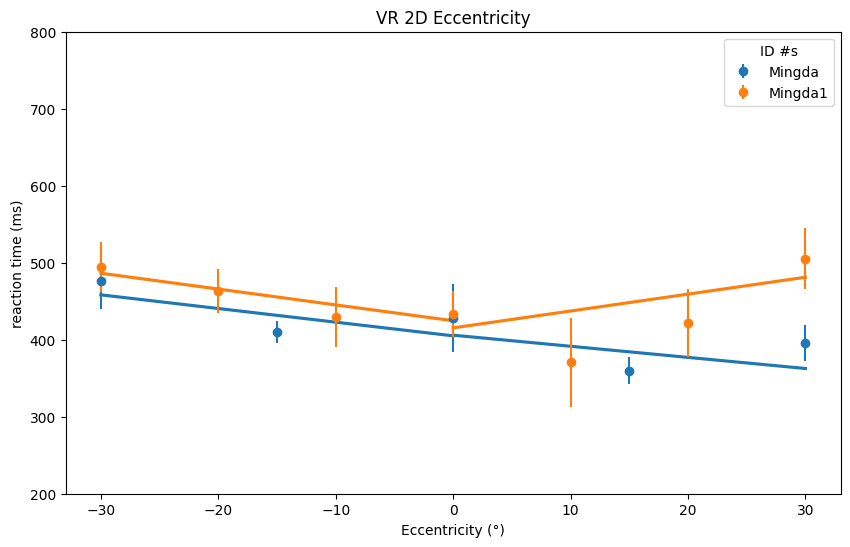

Full Data:
  ParticipantID  IV  reaction_time
0        Mingda -30            364
1        Mingda -30            363
2        Mingda -30            410
3        Mingda -30            665
4        Mingda -30            537
Left IV Filtered Data:
  ParticipantID  IV  reaction_time
0        Mingda -30            364
1        Mingda -30            363
2        Mingda -30            410
3        Mingda -30            665
4        Mingda -30            537
Right IV Filtered Data:
   ParticipantID  IV  reaction_time
21        Mingda   0            555
22        Mingda   0            556
23        Mingda   0            324
24        Mingda   0            430
25        Mingda   0            397


In [316]:
if normalizeData:
    participant_weighted_means = data['weightedMean']
    participant_weights = data['weightedStdErr']
    #  Calculate the overall weighted mean
    protocol_weighted_mean = (participant_weighted_means * participant_weights).sum() / participant_weights.sum()

# Create an empty DataFrame for storing the new data
plotting_data = pd.DataFrame(columns=['ParticipantID', 'IV', 'reaction_time'])
# List to store new rows before creating the final DataFrame
new_rows = [
    {'ParticipantID': participant_id, 'IV': iv, 'reaction_time': rt}
    for idx in range(len(data))
    for participant_id, stats in zip([data.iloc[idx]['ParticipantID']], [data.iloc[idx]['stats']])
    for stat_idx in range(len(stats))
    for iv, reaction_times in zip([stats.iloc[stat_idx]['IndependentVar']], [stats.iloc[stat_idx]['Data']])
    for rt in reaction_times
]
# Convert the list of new rows to a DataFrame and concatenate it with plotting_data
plotting_data = pd.concat([plotting_data, pd.DataFrame(new_rows)], ignore_index=True)
# Convert IV and reaction_time columns to numeric, forcing any errors to NaN
plotting_data['IV'] = pd.to_numeric(plotting_data['IV'], errors='coerce')
plotting_data['reaction_time'] = pd.to_numeric(plotting_data['reaction_time'], errors='coerce')
# Normalize reaction times by subtracting the weightedMean and then adding protocol_weighted_mean
if normalizeData:
    # Merge the weightedMean into plotting_data based on ParticipantID
    plotting_data = plotting_data.merge(data[['ParticipantID', 'weightedMean']], on='ParticipantID', how='left')
    # Subtract the weightedMean from reaction_time
    plotting_data['reaction_time'] = plotting_data['reaction_time'] - plotting_data['weightedMean']
    # Drop the weightedMean column as it is no longer needed
    plotting_data = plotting_data.drop(columns=['weightedMean'])
    # Add the protocol_weighted_mean to all reaction times
    plotting_data['reaction_time'] = plotting_data['reaction_time'] + protocol_weighted_mean

# Filter data for IVs for the left best fit line
filtered_data_left = plotting_data[(plotting_data['IV'] >= left_iv_rows[0]) & (plotting_data['IV'] <= left_iv_rows[1])]
# Filter data for IVs for the left best fit line
filtered_data_right = plotting_data[(plotting_data['IV'] >= right_iv_rows[0]) & (plotting_data['IV'] <= right_iv_rows[1])]

# Create figure
plt.figure(figsize=(10, 6))

# Loop over each participant to add a best-fit line for the range -30 to 0
participants = plotting_data['ParticipantID'].unique()
for participant in participants:
    
    # Find the row corresponding to the specific ParticipantID
    currentDataStats = data.loc[data['ParticipantID'] == participant, 'stats'].values[0]

    # Get the means and standard errors directly from currentDataStats
    mean_values = currentDataStats.set_index('IndependentVar')['Mean']
    std_errors = currentDataStats.set_index('IndependentVar')['Std Err']
    
    # Plot the mean and SEM as error bars for the first range
    plt.errorbar(
        x=mean_values.index,
        y=mean_values.values,
        yerr=std_errors.values,
        fmt='o',
        label=participant,
        color=sns.color_palette()[list(participants).index(participant)]
    )

    # Filter data for the current participant and the first IV range (-30 to 0)
    participant_data_left = filtered_data_left[filtered_data_left['ParticipantID'] == participant]

    # Fit a regression line for the first range
    sns.regplot(
        data=participant_data_left, 
        x='IV', 
        y='reaction_time', 
        scatter=False, 
        ci = None,
        color=sns.color_palette()[list(participants).index(participant)]
    )
    
    # Filter data for the current participant and the second IV range (0 to -30)
    participant_data_right = filtered_data_right[filtered_data_right['ParticipantID'] == participant]
    
    # Fit a regression line for the second range
    sns.regplot(
        data=participant_data_right, 
        x='IV', 
        y='reaction_time', 
        scatter=False, 
        ci = None,
        color=sns.color_palette()[list(participants).index(participant)],
    )

# Add titles and labels
plt.title(plot_title)
plt.xlabel(plot_x_label)
plt.ylabel(plot_y_label)

# Set the y-axis limits
plt.ylim(plot_y_limits[0], plot_y_limits[1])

# Show the plot with a legend
plt.legend(title='ID #s')
plt.show()

print("Full Data:")
print(plotting_data.head())

print("Left IV Filtered Data:")
print(filtered_data_left.head())

print("Right IV Filtered Data:")
print(filtered_data_right.head())


# Examples for Plotting

In [317]:

from scipy.optimize import curve_fit

In [318]:
"""
# Example 1: Plotting a histogram of all the data from a single participant
i = 0  # Index for the participant
currentData = data.iloc[i][3]  # Accessing the 'cleaned trials' column

# Calculate the difference
reactionTimes = currentData['ReactionTime'] - currentData['ObjShowTime']

mean_value = reactionTimes.mean()
std_deviation = reactionTimes.std()

# Define Gaussian function
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(- (x - mu) ** 2 / (2 * sigma ** 2))

# Histogram data
hist, bin_edges = np.histogram(reactionTimes, bins=range(int(reactionTimes.min()), 
                  int(reactionTimes.max()) + 25, 25), density=True)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit Gaussian
popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=[1, mean_value, std_deviation])

# Extract the mean and standard deviation of the fitted Gaussian
fitted_amp, fitted_mean, fitted_std = popt

# Output mean and standard deviation
print(f"Mean: {mean_value:.2f} ms")
print(f"Standard Deviation: {std_deviation:.2f} ms")

# Output mean and standard deviation of the fitted Gaussian
print(f"Fitted Gaussian Mean: {fitted_mean:.2f} ms")
print(f"Fitted Gaussian Standard Deviation: {fitted_std:.2f} ms")

# Plot the histogram and the fitted Gaussian
plt.figure(figsize=(10, 6))
sns.histplot(reactionTimes, bins=bin_edges, kde=False, stat='density')
plt.axvline(mean_value, linestyle='solid', linewidth=1, label=f'Mean: {mean_value:.2f} ms')
plt.axvline(mean_value + std_deviation, linestyle='dashed', linewidth=1, label=f'Standard Deviation: {std_deviation:.2f} ms')
plt.axvline(mean_value - std_deviation, linestyle='dashed', linewidth=1)

# Plot Gaussian fit
x_fit = np.linspace(mean_value - 4*std_deviation, mean_value + 4*std_deviation, 1000)
y_fit = gaussian(x_fit, *popt)
plt.plot(x_fit, y_fit, linewidth=2, label=f'Gaussian Fit: μ = {fitted_mean:.2f} ms, σ = {fitted_std:.2f} ms')

plt.title(f'Histogram for Participant {data.iloc[i]['ParticipantID']}')
plt.xlabel('Reaction Time (ms)')
plt.ylabel('Frequency Density')
plt.legend()
plt.show()
"""

'\n# Example 1: Plotting a histogram of all the data from a single participant\ni = 0  # Index for the participant\ncurrentData = data.iloc[i][3]  # Accessing the \'cleaned trials\' column\n\n# Calculate the difference\nreactionTimes = currentData[\'ReactionTime\'] - currentData[\'ObjShowTime\']\n\nmean_value = reactionTimes.mean()\nstd_deviation = reactionTimes.std()\n\n# Define Gaussian function\ndef gaussian(x, amp, mu, sigma):\n    return amp * np.exp(- (x - mu) ** 2 / (2 * sigma ** 2))\n\n# Histogram data\nhist, bin_edges = np.histogram(reactionTimes, bins=range(int(reactionTimes.min()), \n                  int(reactionTimes.max()) + 25, 25), density=True)\n\nbin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2\n\n# Fit Gaussian\npopt, pcov = curve_fit(gaussian, bin_centers, hist, p0=[1, mean_value, std_deviation])\n\n# Extract the mean and standard deviation of the fitted Gaussian\nfitted_amp, fitted_mean, fitted_std = popt\n\n# Output mean and standard deviation\nprint(f"Mean: {me

In [319]:
"""
# Select a participant (for example, the second participant, i = 1)
i = 1
currentData = data.iloc[i]['stats']

# Select a specific IV (for example, the third IV, j = 2)
j = 6
currentIVData = currentData.iloc[j]['Data']
mean_value = currentData.iloc[j]['Mean']
std_deviation = currentData.iloc[j]['Std Dev']

# Define Gaussian function
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(- (x - mu) ** 2 / (2 * sigma ** 2))

# Histogram data
hist, bin_edges = np.histogram(reactionTimes, bins=range(int(reactionTimes.min()), 
                  int(reactionTimes.max()) + 25, 25), density=True)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit Gaussian
popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=[1, mean_value, std_deviation])

# Extract the mean and standard deviation of the fitted Gaussian
fitted_amp, fitted_mean, fitted_std = popt

# Output mean and standard deviation
print(f"Mean: {mean_value:.2f} ms")
print(f"Standard Deviation: {std_deviation:.2f} ms")

# Output mean and standard deviation of the fitted Gaussian
print(f"Fitted Gaussian Mean: {fitted_mean:.2f} ms")
print(f"Fitted Gaussian Standard Deviation: {fitted_std:.2f} ms")

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(currentIVData, stat='density')
plt.axvline(mean_value, linestyle='solid', linewidth=1, label=f'Mean: {mean_value:.2f} ms')
plt.axvline(mean_value + std_deviation, linestyle='dashed', linewidth=1, label=f'Standard Deviation: {std_deviation:.2f} ms')
plt.axvline(mean_value - std_deviation, linestyle='dashed', linewidth=1)

# Plot Gaussian fit
x_fit = np.linspace(mean_value - 4*std_deviation, mean_value + 4*std_deviation, 1000)
y_fit = gaussian(x_fit, *popt)
plt.plot(x_fit, y_fit, linewidth=2, label=f'Gaussian Fit: μ = {fitted_mean:.2f} ms, σ = {fitted_std:.2f} ms')

plt.title(f"Histogram of Reaction Times for Participant {data.iloc[i]['ParticipantID']} and IV {currentData.iloc[j]['IndependentVar']}")
plt.xlabel("Reaction Time (ms)")
plt.ylabel("Frequency Density")
plt.legend()
plt.show()
"""

'\n# Select a participant (for example, the second participant, i = 1)\ni = 1\ncurrentData = data.iloc[i][\'stats\']\n\n# Select a specific IV (for example, the third IV, j = 2)\nj = 6\ncurrentIVData = currentData.iloc[j][\'Data\']\nmean_value = currentData.iloc[j][\'Mean\']\nstd_deviation = currentData.iloc[j][\'Std Dev\']\n\n# Define Gaussian function\ndef gaussian(x, amp, mu, sigma):\n    return amp * np.exp(- (x - mu) ** 2 / (2 * sigma ** 2))\n\n# Histogram data\nhist, bin_edges = np.histogram(reactionTimes, bins=range(int(reactionTimes.min()), \n                  int(reactionTimes.max()) + 25, 25), density=True)\n\nbin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2\n\n# Fit Gaussian\npopt, pcov = curve_fit(gaussian, bin_centers, hist, p0=[1, mean_value, std_deviation])\n\n# Extract the mean and standard deviation of the fitted Gaussian\nfitted_amp, fitted_mean, fitted_std = popt\n\n# Output mean and standard deviation\nprint(f"Mean: {mean_value:.2f} ms")\nprint(f"Standard Deviatio

In [320]:
"""
# Select a participant (for example, the first participant, i = 1)
i = 1
currentData = data.iloc[i]['stats']
zScore = 1.96  # for 95% confidence interval

# Method 1: Plot each mean and standard error individually
plt.figure()
for j in range(len(currentData)):
    mean = currentData.iloc[j]['Mean']
    standard_error = currentData.iloc[j]['Std Err']
    plt.errorbar(j+1, mean, yerr=standard_error*zScore, fmt='o', label=f'IV{j+1}')
    plt.scatter(j+1, mean, color='red')

plt.title(f'Means and Standard Errors for Participant {data.iloc[i]["ParticipantID"]}')
plt.xlabel('Independent Variable')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

# Method 2: Plot all means and standard errors together
plt.figure()
xVals = range(1, len(currentData) + 1)
means = currentData['Mean']
standard_errors = currentData['Std Err']

plt.errorbar(xVals, means, yerr=standard_errors*zScore, fmt='o', label='Means with 95% Conf Interval')
plt.scatter(xVals, means, color='red')

plt.title(f'Means and Standard Errors for Participant {data.iloc[i]["ParticipantID"]}')
plt.xlabel('Independent Variable')
plt.ylabel('Mean Value')
plt.legend()
plt.show()
"""

'\n# Select a participant (for example, the first participant, i = 1)\ni = 1\ncurrentData = data.iloc[i][\'stats\']\nzScore = 1.96  # for 95% confidence interval\n\n# Method 1: Plot each mean and standard error individually\nplt.figure()\nfor j in range(len(currentData)):\n    mean = currentData.iloc[j][\'Mean\']\n    standard_error = currentData.iloc[j][\'Std Err\']\n    plt.errorbar(j+1, mean, yerr=standard_error*zScore, fmt=\'o\', label=f\'IV{j+1}\')\n    plt.scatter(j+1, mean, color=\'red\')\n\nplt.title(f\'Means and Standard Errors for Participant {data.iloc[i]["ParticipantID"]}\')\nplt.xlabel(\'Independent Variable\')\nplt.ylabel(\'Mean Value\')\nplt.legend()\nplt.show()\n\n# Method 2: Plot all means and standard errors together\nplt.figure()\nxVals = range(1, len(currentData) + 1)\nmeans = currentData[\'Mean\']\nstandard_errors = currentData[\'Std Err\']\n\nplt.errorbar(xVals, means, yerr=standard_errors*zScore, fmt=\'o\', label=\'Means with 95% Conf Interval\')\nplt.scatter(xVa